In [475]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

In [476]:
path = Path('../submissions/submission_latest.csv')
df = pd.read_csv(path)
print(path.name)

submission_latest.csv


In [477]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   patientId         3000 non-null   object
 1   PredictionString  1371 non-null   object
dtypes: object(2)
memory usage: 47.0+ KB


In [478]:
df['pred_count'] = df['PredictionString'].apply(lambda x: 0 if pd.isna(x) else int(len(x.split()) / 5))
df['pred_count'].value_counts().sort_index()

pred_count
0    1629
1     735
2     477
3     146
4      12
5       1
Name: count, dtype: int64

In [479]:
def str_to_boxes(s: str) -> list:  # return c,x,y,w,h
    if pd.isna(s) or len(s) == 0:
        return []

    boxes = []
    n = len(s.split()) // 5
    for i in range(n):
        box = s.split()[i * 5:i * 5 + 5]
        boxes.append(list(map(float, box)))

    return boxes


In [480]:
def remove_empty_boxes(s: str) -> str:
    if pd.isna(s) or len(s) == 0:
        return s

    n = len(s.split()) // 5
    for i in range(n):
        box = s.split()[i * 5:i * 5 + 5]
        if float(box[2]) * float(box[3]) == 0:
            s = s.replace(' '.join(map(str, box)), '').strip()

    return s

In [481]:
df['PredictionString'] = df['PredictionString'].apply(remove_empty_boxes)

In [482]:
def box_areas_utils(box1, box2):  # corner coords
    _, left_x1, left_y1, w1, h1 = box1
    _, left_x2, left_y2, w2, h2 = box2

    assert w1 * h1 * w2 * h2 > 0, 'w or h is 0'

    right_x1, right_x2 = left_x1 + w1, left_x2 + w2
    top_y1, top_y2 = left_y1 + h1, left_y2 + h2

    area1, area2 = w1 * h1, w2 * h2
    right_xi = min(right_x1, right_x2)
    left_xi = max(left_x1, left_x2)
    top_yi = min(top_y1, top_y2)
    bottom_yi = max(left_y1, left_y2)

    if right_xi <= left_xi or top_yi <= bottom_yi:
        intersection = 0
    else:
        intersection = (right_xi - left_xi) * (top_yi - bottom_yi)

    union = area1 + area2 - intersection
    return area1, area2, intersection, union


def iou(box1, box2):
    area1, area2, intersection, union = box_areas_utils(box1, box2)
    return intersection / union


def two_boxes_overlap(box1, box2) -> bool:
    return iou(box1, box2) > 0.3


def one_box_inside_another(box1, box2) -> bool:
    area1, area2, intersection, union = box_areas_utils(box1, box2)
    return intersection / area1 > 0.7 or intersection / area2 > 0.7


def merge_boxes(box1, box2) -> (float, float, float, float, float):  # c,x,y,w,h - bottom left corner (0,0)
    c1, x1, y1, w1, h1 = box1
    c2, x2, y2, w2, h2 = box2
    min_x, min_y = min([x1, x2]), min([y1, y2])
    max_x, max_y = max([x1 + w1, x2 + w2]), max([y1 + h1, y2 + h2])

    w, h = max_x - min_x, max_y - min_y
    # reduce w, h by 10%
    dw, dh = w * 0.05, h * 0.05
    w, h = w * 0.9, h * 0.9

    return (c1 + c2) / 2, (x1 + x2) / 2, (y1 + y2) / 2, (w1+w2) / 2, (h1+h2) / 2


def detect_overlapping(s: str, type='both') -> bool:
    if pd.isna(s):
        return False

    n = len(s.split()) // 5
    for i in range(n):
        box1 = list(map(float, s.split()[i * 5:i * 5 + 5]))
        for j in range(n):
            if i == j:
                continue
            box2 = list(map(float, s.split()[j * 5:j * 5 + 5]))

            if type == 'both':
                if two_boxes_overlap(box1, box2) or one_box_inside_another(box1, box2):
                    return True
            elif type == 'overlap':
                if two_boxes_overlap(box1, box2) and not one_box_inside_another(box1, box2):
                    return True
            elif type == 'inside':
                if one_box_inside_another(box1, box2):
                    return True

    return False


def merge_overlapping(s: str) -> str:
    if pd.isna(s):
        return s

    boxes = str_to_boxes(s)

    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            if boxes[i] is None or boxes[j] is None:
                continue
            if two_boxes_overlap(boxes[i], boxes[j]) or \
                    one_box_inside_another(boxes[i], boxes[j]):
                boxes[i] = merge_boxes(boxes[i], boxes[j])
                boxes[j] = None

    return ' '.join([' '.join(map(str, c)) for c in boxes if c is not None]).strip()



In [483]:
df['overlaps'] = df['PredictionString'].apply(lambda s: detect_overlapping(s, type='overlap'));
df['inside_box'] = df['PredictionString'].apply(lambda s: detect_overlapping(s, type='inside'));
print(df.query('pred_count>0')['overlaps'].value_counts())
print(df.query('pred_count>0')['inside_box'].value_counts())

overlaps
False    1369
True        2
Name: count, dtype: int64
inside_box
False    1134
True      237
Name: count, dtype: int64


In [484]:
df[df['overlaps']]['pred_count'].value_counts().sort_index()

pred_count
3    2
Name: count, dtype: int64

In [485]:
df['PredictionString_'] = df['PredictionString']

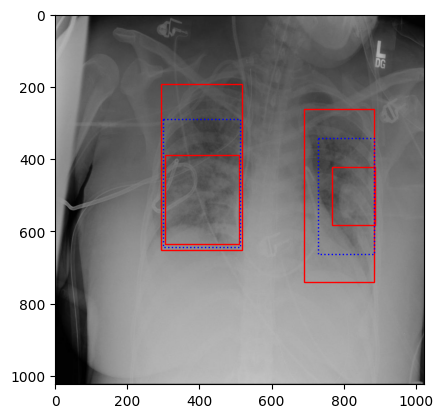

In [493]:
s = df.query('inside_box').sample(1).iloc[0]

img = Image.open(f'../dataset/{s["patientId"]}.jpg')
img = img.convert('RGB')
ax = plt.gca()
boxes = str_to_boxes(s['PredictionString_'])
for b in boxes:
    rect = patches.Rectangle((b[1], b[2]), b[3], b[4], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

fixed_s = merge_overlapping(s['PredictionString_'])
boxes_fixed = str_to_boxes(fixed_s)
for b in boxes_fixed:
    rect = patches.Rectangle((b[1], b[2]), b[3], b[4], linewidth=1, edgecolor='b', facecolor='none', linestyle=':')
    ax.add_patch(rect)
plt.imshow(img);

In [487]:
df['PredictionString'] = df['PredictionString'].apply(merge_overlapping)

In [488]:
df[['patientId', 'PredictionString']].to_csv(path.with_name(path.stem + '_overlap_cleaned.csv'), index=False)

In [489]:
path.with_name(path.stem + '_overlap_cleaned.csv')

WindowsPath('../submissions/submission_latest_overlap_cleaned.csv')